## 1. **Image Filtering and Subtraction Using Gaussian Filter**
This method uses a Gaussian filter from scipy to estimate the background and then subtracts it from the original image.

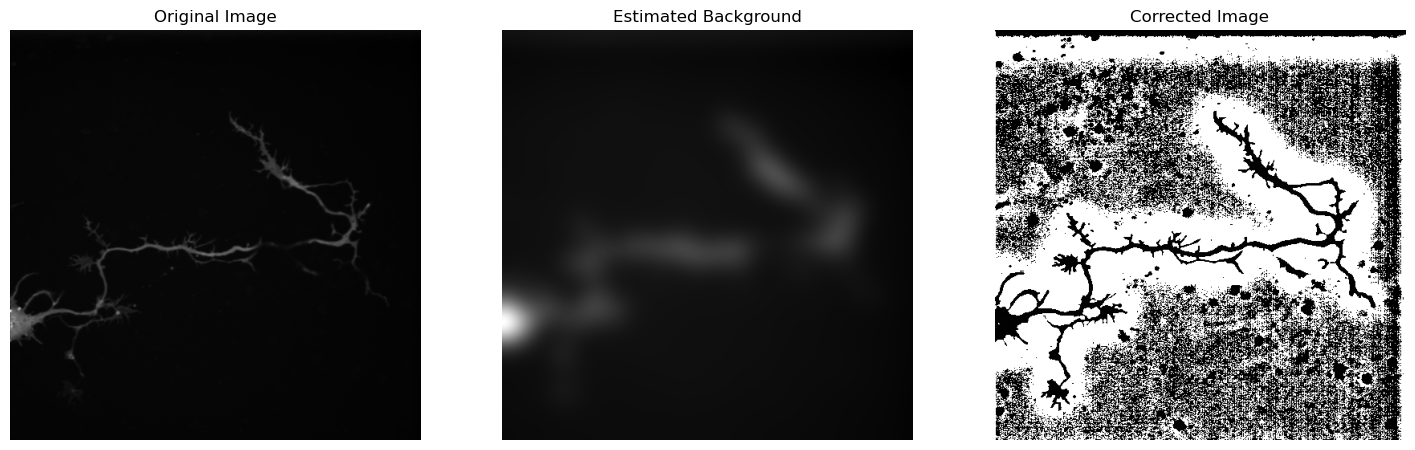

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import io, img_as_float
import tifffile as tiff
from skimage.morphology import white_tophat, disk, rectangle
from skimage import measure, morphology
from skimage.measure import label, regionprops
from skimage.exposure import equalize_adapthist, is_low_contrast
from numpy.polynomial.polynomial import polyvander2d, Polynomial
from skimage.filters import threshold_otsu, threshold_local
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import warnings
warnings.filterwarnings("ignore")

# Load the microscopy image
data_folder = 'E:\Spandan\Kate_2024\Flat\div2\control_div2_glass_2019_06_24_cortical_timelapse2_1'

file_name = 'AVG_cortical_div2_timelapse2_1dft'
image = tiff.imread(data_folder+'\\'+file_name+'.tif') 

# Apply a Gaussian filter to estimate the background illumination
blurred = gaussian_filter(image, sigma=15)

# Subtract the blurred image from the original image
corrected = image - blurred

# Clip any negative values to zero
corrected[corrected < 0] = 0

# Display the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Estimated Background')
plt.imshow(blurred, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Corrected Image')
plt.imshow(corrected, cmap='gray')
plt.axis('off')

plt.show()

## 2. **Top-hat Filtering with Different Structuring Elements**
Top-hat filtering can be applied with different structuring elements (e.g., disk, line, rectangle) to estimate and remove the background more effectively for specific types of background variations.

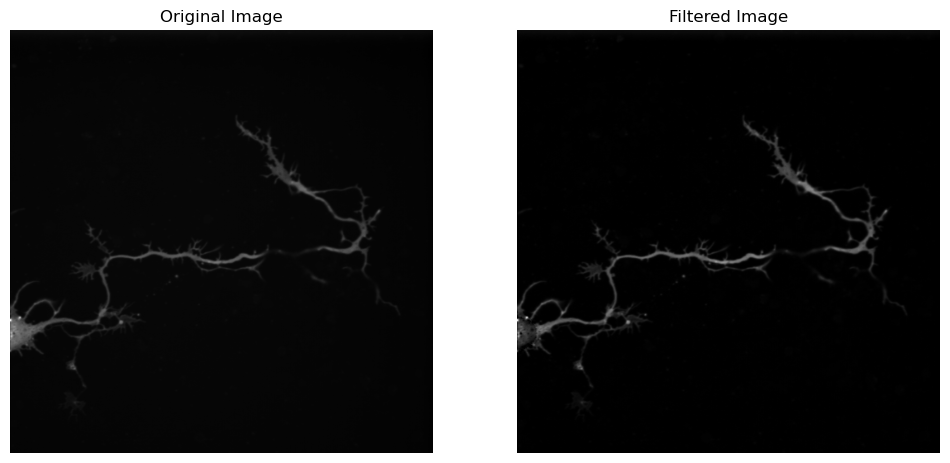

In [50]:
# Create a ball-shaped (or rectangular) structuring element
selem = disk(radius=15)
# selem = rectangle(30, 5)

# Apply the white tophat filter with the structuring element
corrected_tphat = white_tophat(image, selem)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Filtered Image')
plt.imshow(corrected_tphat, cmap='gray')
plt.axis('off')

plt.show()


## 3. **CLAHE (Contrast Limited Adaptive Histogram Equalization) Using skimage**
*skimage.exposure.equalize_adapthist* provides a way to perform CLAHE without OpenCV.

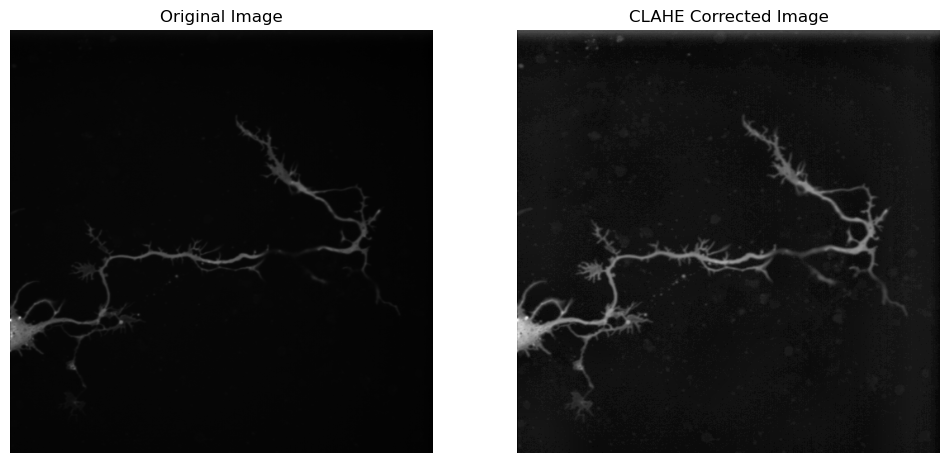

In [51]:
# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
corrected = equalize_adapthist(image, clip_limit=0.03)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('CLAHE Corrected Image')
plt.imshow(corrected, cmap='gray')
plt.axis('off')

plt.show()


## 4. **Image Normalization Using NumPy**
Normalization can adjust the intensity values of the image to a standard range, which can sometimes help to correct uneven illumination.

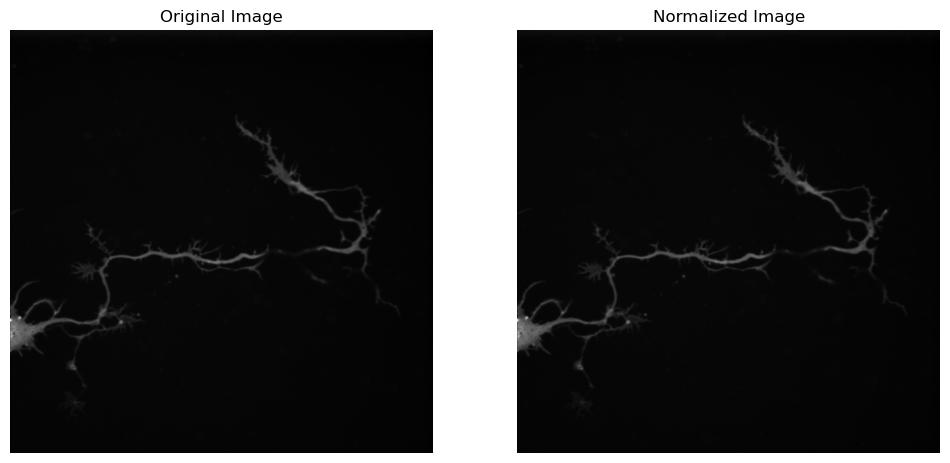

In [52]:
# Normalize the image to have values between 0 and 1
normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Normalized Image')
plt.imshow(normalized_image, cmap='gray')
plt.axis('off')

plt.show()


### Check if the input image has low-contrast:

In [53]:
is_low_contrast(image, fraction_threshold=0.05, lower_percentile=1, upper_percentile=99, method='linear')

True

## 5. **Polynomial Fitting for Background Estimation**
This method involves fitting a polynomial surface to the image to estimate the background. This approach works well if the background varies smoothly across the image.

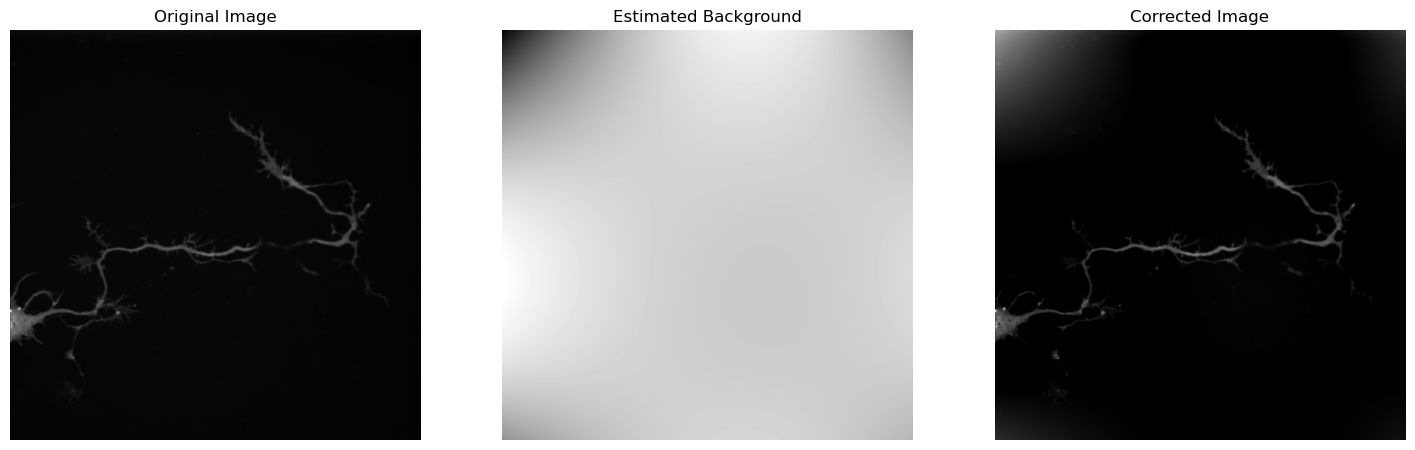

In [54]:
# Create a grid of x, y coordinates
x = np.arange(image.shape[1])
y = np.arange(image.shape[0])
X, Y = np.meshgrid(x, y)

# Flatten the coordinates and image for fitting
X_flat = X.ravel()
Y_flat = Y.ravel()
image_flat = image.ravel()

# Degree of polynomial
degree = 2

# Design matrix for polynomial fitting
V = polyvander2d(X_flat, Y_flat, [degree, degree])

# Solve for polynomial coefficients
coefficients, _, _, _ = np.linalg.lstsq(V, image_flat, rcond=None)

# Evaluate the polynomial surface (background estimation)
background = np.polynomial.polynomial.polyval2d(X, Y, coefficients.reshape((degree+1, degree+1)))

# Subtract the estimated background from the original image
corrected = image - background

# Clip any negative values to zero
corrected[corrected < 0] = 0

# Display the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Estimated Background')
plt.imshow(background, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Corrected Image')
plt.imshow(corrected, cmap='gray')
plt.axis('off')

plt.show()



## 6. **Fourier Transform Filtering**
Fourier transform filtering can be used to remove low-frequency components (background illumination) from an image. This technique is effective for images where the background varies in a regular, predictable manner.

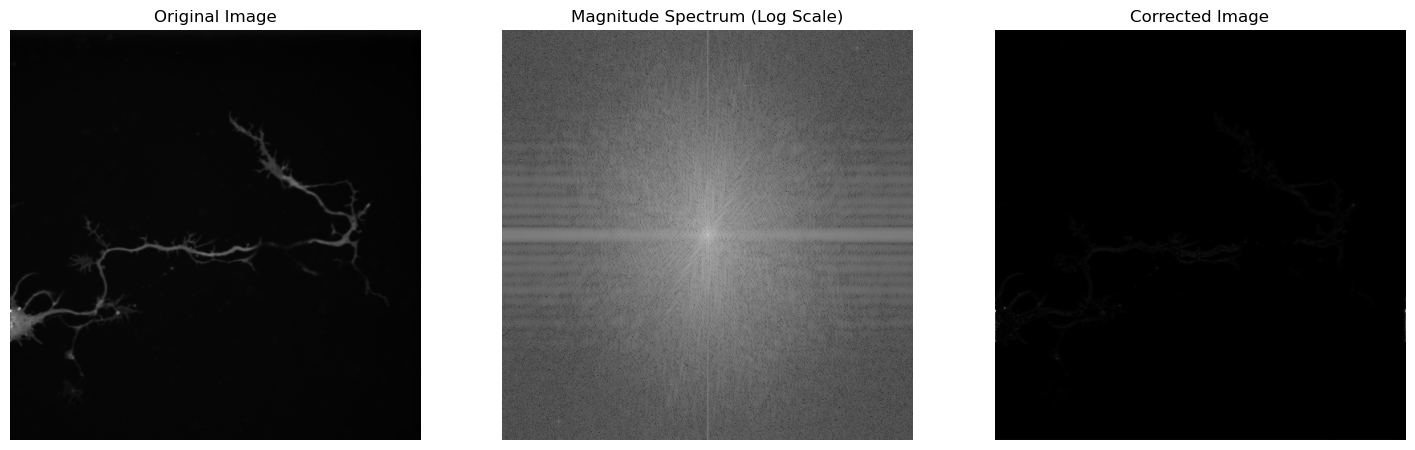

In [58]:
# Perform the 2D Fourier transform
f_transform = fft2(image)
f_transform_shifted = fftshift(f_transform)

# Create a Gaussian high-pass filter
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2

# Set the standard deviation for the Gaussian filter
sigma = 2  # Adjust this parameter based on your specific image

# Create the Gaussian high-pass filter
X, Y = np.meshgrid(np.linspace(-0.5, 0.5, cols), np.linspace(-0.5, 0.5, rows))
d = np.sqrt(X**2 + Y**2)
high_pass_filter = 1 - np.exp(-((d**2) / (2.0 * (sigma ** 2))))

# Apply the high-pass filter in the frequency domain
f_transform_shifted_filtered = f_transform_shifted * high_pass_filter

# Perform the inverse Fourier transform to get the filtered image
f_transform_filtered = ifftshift(f_transform_shifted_filtered)
corrected = np.abs(ifft2(f_transform_filtered))

# Display the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Magnitude Spectrum (Log Scale)')
plt.imshow(np.log(1 + np.abs(f_transform_shifted)), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Corrected Image')
plt.imshow(corrected, cmap='gray')
plt.axis('off')

plt.show()


## 7. **Image Segmentation and Background Subtraction**
This method involves segmenting the image to separate the background from the foreground. After segmentation, you can estimate the background based on the segmented regions.

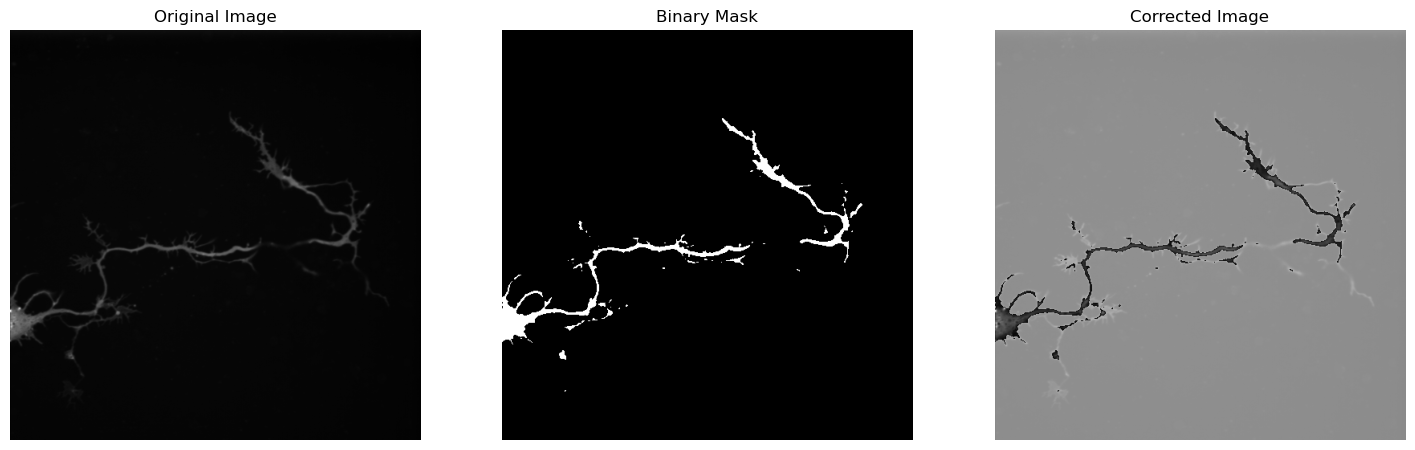

In [59]:
# Apply Otsu's threshold to segment the image
thresh = threshold_otsu(image)
binary_mask = image > thresh

# Estimate the background using the Gaussian filter
background = gaussian_filter(image, sigma=60)

# Correct the image using the segmented mask
corrected = np.where(binary_mask, image - background, image)

# Clip any negative values to zero
corrected[corrected < 0] = 0

# Display the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Binary Mask')
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Corrected Image')
plt.imshow(corrected, cmap='gray')
plt.axis('off')

plt.show()


## **8. Adaptive Thresholding**
Adaptive thresholding can be used to correct non-uniform illumination by applying different thresholds to different regions of the image. This method is useful when the background has varying illumination across different parts of the image.

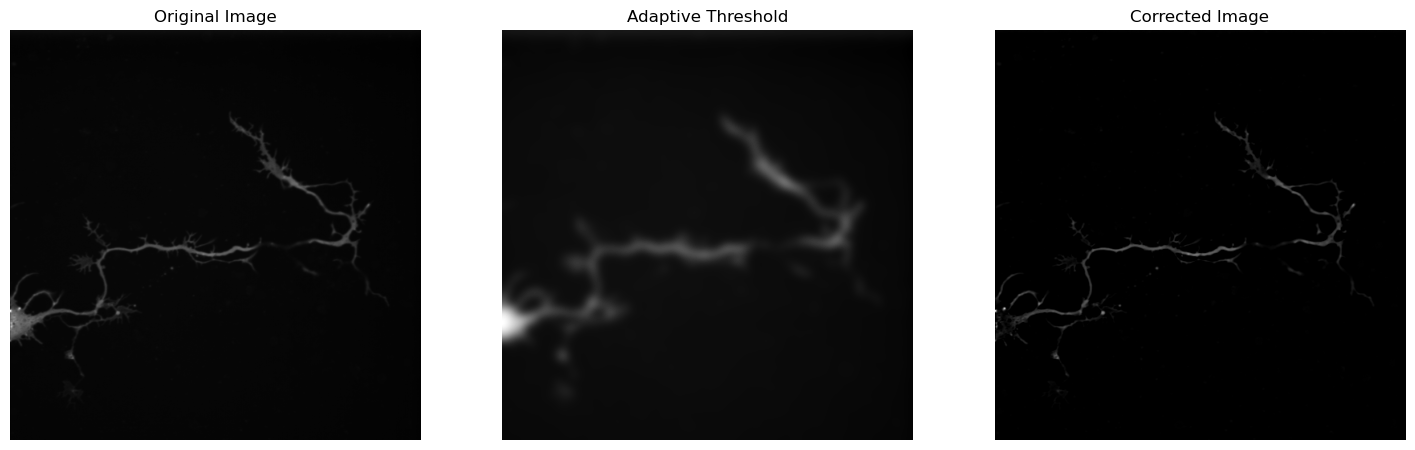

In [60]:
# Apply adaptive (local) thresholding
block_size = 35
adaptive_thresh = threshold_local(image, block_size, offset=0.01)

# Subtract the background estimated by adaptive thresholding
adapt_corrected = image - adaptive_thresh

# Clip any negative values to zero
adapt_corrected[adapt_corrected < 0] = 0

# Display the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adaptive Threshold')
plt.imshow(adaptive_thresh, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Corrected Image')
plt.imshow(adapt_corrected, cmap='gray')
plt.axis('off')

plt.show()


### Check which has performed the best (top-hat filtering or adaptive thresholding)

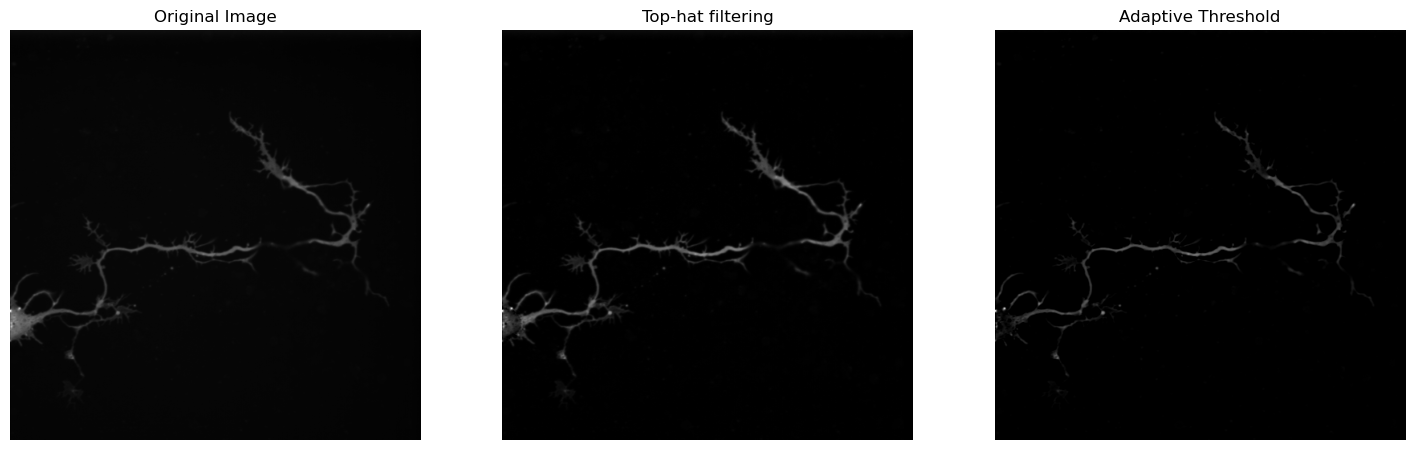

In [61]:
# Display the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Top-hat filtering')
plt.imshow(corrected_tphat, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Adaptive Threshold')
plt.imshow(adapt_corrected, cmap='gray')
plt.axis('off')

plt.show()

### Using same threshold for binary masking

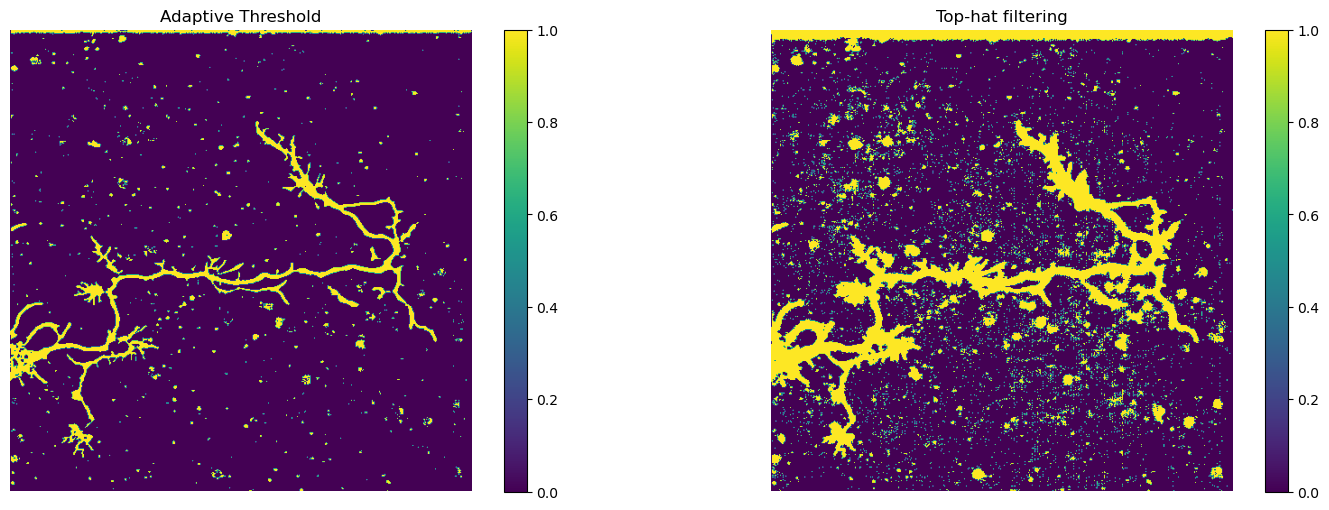

In [70]:
thresh = 0.005

# Display the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')

plt.axis('off')

plt.subplot(1, 2, 1)
plt.title('Adaptive Threshold')
plt.imshow(adapt_corrected/adapt_corrected.max() > thresh); plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Top-hat filtering')
plt.imshow(corrected_tphat/corrected_tphat.max() > thresh); plt.colorbar()
plt.axis('off')

plt.show()

### Extract the final mask using the largest connected component of the raw mask
#### For masking we use the adaptive thresholded image or top-hat filtered image

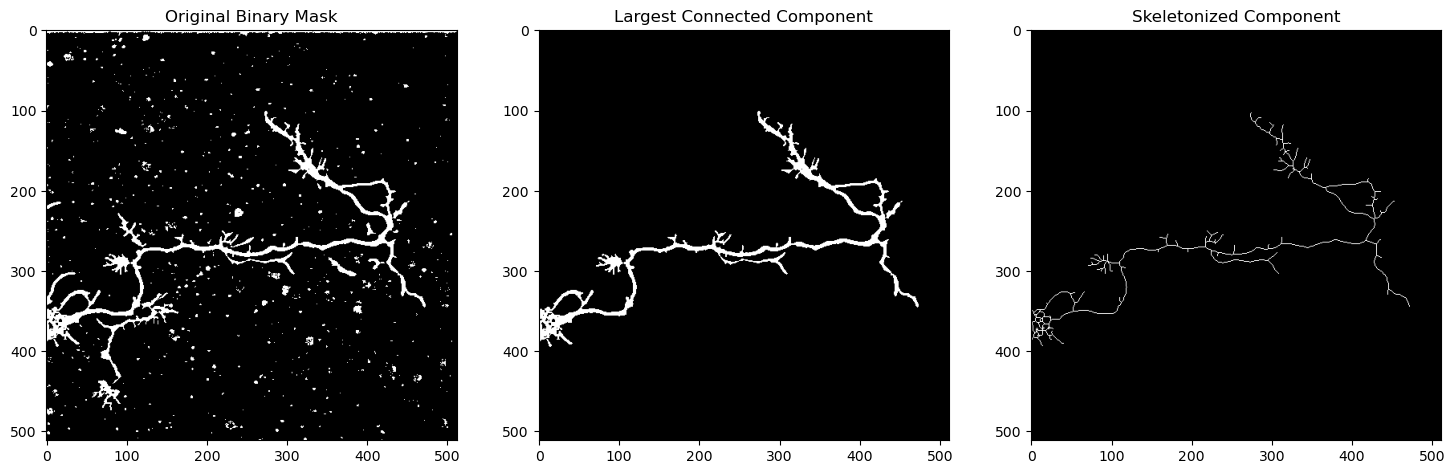

In [71]:
# binary_mask = corrected_tphat/corrected_tphat.max() > thresh
binary_mask = adapt_corrected/adapt_corrected.max() > thresh

def get_largest_components(binary_mask, n=1):

    # Label connected components
    labeled_mask, num_features = label(binary_mask, return_num=True, connectivity=2)
    
    # Extract properties of labeled regions
    properties = regionprops(labeled_mask)
    
    # Sort regions by area (size) in descending order
    sorted_regions = sorted(properties, key=lambda x: x.area, reverse=True)
    
    # Create an empty mask for the largest components
    largest_components_mask = np.zeros_like(binary_mask)
    
    # Iterate over the top n regions and add them to the mask
    for i in range(min(n, len(sorted_regions))):
        largest_components_mask[labeled_mask == sorted_regions[i].label] = 1
   
    return largest_components_mask

def skeletonize_component(binary_mask):

    # Get the largest connected component
    largest_component = get_largest_components(binary_mask)
    
    # Skeletonize the largest component
    skeleton = morphology.skeletonize(largest_component)
    
    return skeleton
    

# Get the largest n connected components
n = 1
largest_components = get_largest_components(binary_mask, n)

# Skeletonize the largest connected component
skeleton = skeletonize_component(binary_mask)

# Display the original, largest component, and skeletonized images
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(binary_mask, cmap='gray')
ax[0].set_title('Original Binary Mask')

ax[1].imshow(get_largest_components(binary_mask), cmap='gray')
ax[1].set_title('Largest Connected Component')

ax[2].imshow(skeleton, cmap='gray')
ax[2].set_title('Skeletonized Component')

plt.show()
